In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import math
import sys

# --- Cấu hình ---
# Đường dẫn file gốc của bạn (khoảng 400KB)
original_small_file_path = 'C:\CODE\Python\smart_meter_data.csv'
# Đường dẫn file đầu ra 11GB (Không nén)
output_large_file_path = '11gb_data.csv'

# Kích thước mục tiêu của file (bytes) - khoảng 11GB
TARGET_FILE_SIZE_BYTES = 11 * 1024**3 # 11 GB
# Kích thước chunk để ghi ra file (số hàng) - GIẢM XUỐNG CỰC KỲ NHỎ
CHUNK_SIZE_WRITE_ROWS = 10_000 # Giảm từ 50,000 xuống 10,000

# Giả định tần suất dữ liệu là 30 phút
FREQ = '30min'
ROWS_PER_HOUR = 2
ROWS_PER_DAY = ROWS_PER_HOUR * 24 # 48

# --- Cấu hình cho việc sinh nhiều Meter_ID ---
ESTIMATED_BYTES_PER_ROW_UNCOMPRESSED = 90 # Ước tính kích thước mỗi hàng trong CSV
TOTAL_ROWS_TARGET = TARGET_FILE_SIZE_BYTES // ESTIMATED_BYTES_PER_ROW_UNCOMPRESSED

# Ngày bắt đầu cho chuỗi thời gian của mỗi công tơ
start_gen_date_overall = datetime(2000, 1, 1)

# Số lượng công tơ theo yêu cầu
NUM_METERS_TO_GENERATE = 300

# Tính toán số hàng thực tế cho mỗi công tơ để đạt tổng số hàng mục tiêu
ACTUAL_ROWS_PER_METER = TOTAL_ROWS_TARGET // NUM_METERS_TO_GENERATE
ACTUAL_DAYS_PER_METER = ACTUAL_ROWS_PER_METER // ROWS_PER_DAY
ACTUAL_YEARS_PER_METER = ACTUAL_DAYS_PER_METER / 365.25


print(f"Tổng số hàng mục tiêu: {TOTAL_ROWS_TARGET:,}")
print(f"Ngày bắt đầu cho mỗi công tơ: {start_gen_date_overall.strftime('%Y-%m-%d')}")
print(f"Số lượng công tơ sẽ sinh: {NUM_METERS_TO_GENERATE:,}")
print(f"Mỗi công tơ sẽ có khoảng: {ACTUAL_ROWS_PER_METER:,} hàng (~{ACTUAL_YEARS_PER_METER:.2f} năm dữ liệu).")
print(f"Dữ liệu của mỗi công tơ sẽ kéo dài đến khoảng năm: {(start_gen_date_overall.year + ACTUAL_YEARS_PER_METER):.0f}.")

# --- Bước 1: Đọc và phân tích file gốc nhỏ ---
print(f"\nĐọc file gốc nhỏ để phân tích mẫu: {original_small_file_path}")
try:
    df_original = pd.read_csv(
        original_small_file_path,
        parse_dates=['Timestamp'],
    )
    df_original = df_original.set_index('Timestamp').sort_index()

    if 'Anomaly_Label' in df_original.columns:
        df_original = df_original.drop(columns=['Anomaly_Label'])

    target_column = 'Electricity_Consumed'
    if target_column not in df_original.columns:
        candidate_cols = [col for col in df_original.columns if pd.api.types.is_numeric_dtype(df_original[col])]
        if candidate_cols:
            target_column = candidate_cols[0]
            print(f"Cảnh báo: Không tìm thấy cột '{target_column}'. Sử dụng cột '{target_column}' làm mục tiêu.")
        else:
            print("Lỗi: Không tìm thấy cột số nào trong dữ liệu gốc để làm mục tiêu.")
            exit()

    print(f"Kích thước file gốc: {df_original.shape} (Hàng, Cột)")
    df_original.info()
    print("Mô tả thống kê của cột mục tiêu:")
    print(df_original[target_column].describe())

    sample_rows_for_pattern = min(ROWS_PER_DAY * 7 * 2, len(df_original)) # Lấy 2 tuần dữ liệu mẫu
    df_sample_pattern = df_original.iloc[:sample_rows_for_pattern].copy()
    df_sample_pattern.reset_index(inplace=True)

    print(f"\nĐã lấy {sample_rows_for_pattern} hàng làm mẫu từ file gốc để tạo quy luật.")

except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy tệp gốc tại đường dẫn: {original_small_file_path}")
    print("Vui lòng đảm bảo file gốc của bạn ('smart_meter_data.csv') có tên chính xác và nằm trong cùng thư mục với script này.")
    exit()
except Exception as e:
    print(f"Đã xảy ra lỗi khi đọc/phân tích file gốc: {e}")
    exit()

# --- Bước 2: Hàm sinh dữ liệu giả lập có quy luật ---
def generate_synthetic_chunk_with_patterns(start_datetime, end_datetime, df_pattern, target_col, total_generation_period_days_for_trend):
    dates = pd.date_range(start=start_datetime, end=end_datetime, freq=FREQ)
    num_rows_in_chunk = len(dates)

    if num_rows_in_chunk == 0:
        return pd.DataFrame()

    df_chunk = pd.DataFrame({'Timestamp': dates})

    df_chunk['hour'] = df_chunk['Timestamp'].dt.hour
    df_chunk['dayofweek'] = df_chunk['Timestamp'].dt.dayofweek
    df_chunk['dayofyear'] = df_chunk['Timestamp'].dt.dayofyear
    df_chunk['month'] = df_chunk['Timestamp'].dt.month
    df_chunk['year'] = df_chunk['Timestamp'].dt.year

    pattern_length = len(df_pattern)
    if pattern_length == 0:
        for col in df_original.columns:
            if col == target_col:
                df_chunk[col] = np.random.uniform(0.3, 0.7, num_rows_in_chunk)
            elif pd.api.types.is_numeric_dtype(df_original[col]):
                df_chunk[col] = np.random.uniform(0.1, 0.9, num_rows_in_chunk)
    else:
        reps = math.ceil(num_rows_in_chunk / pattern_length)
        extended_pattern = pd.concat([df_pattern] * reps, ignore_index=True)

        cols_to_use_from_pattern = [
            col for col in df_pattern.columns
            if col != 'Timestamp' and col != 'Anomaly_Label' and col != 'Meter_ID'
        ]

        for col in cols_to_use_from_pattern:
            if col in extended_pattern.columns and pd.api.types.is_numeric_dtype(df_original[col]):
                df_chunk[col] = extended_pattern[col].iloc[:num_rows_in_chunk].values
            else:
                df_chunk[col] = 0.0

    # --- Thêm Xu hướng (Trend) ---
    overall_start_date_for_trend = start_datetime
    current_day_offset = (df_chunk['Timestamp'].iloc[0] - overall_start_date_for_trend).days
    
    trend_factor = (current_day_offset + np.linspace(0, (end_datetime - start_datetime).days, num_rows_in_chunk)) / (total_generation_period_days_for_trend + 1e-9)
    df_chunk[target_col] = df_chunk[target_col] + 0.05 * (trend_factor - 0.5)

    # --- Thêm Tính thời vụ phụ (Seasonality) ---
    df_chunk[target_col] += 0.15 * np.sin(2 * np.pi * df_chunk['hour'] / 24 - np.pi/4)
    df_chunk[target_col] += 0.08 * np.cos(2 * np.pi * df_chunk['dayofweek'] / 7)

    # --- Tạo mối quan hệ giữa các đặc trưng và biến mục tiêu (nếu các cột này tồn tại) ---
    if 'Temperature' in df_chunk.columns and 'Humidity' in df_chunk.columns:
        optimal_temp = 0.5
        temp_effect = 0.2 * (np.abs(df_chunk['Temperature'] - optimal_temp) ** 2)
        df_chunk[target_col] += temp_effect

        humid_effect = -0.05 * (df_chunk['Humidity'] - 0.5)
        df_chunk[target_col] += humid_effect
        
    if 'Wind_Speed' in df_chunk.columns:
        wind_effect = -0.03 * df_chunk['Wind_Speed']
        df_chunk[target_col] += wind_effect

    # --- Thêm nhiễu ngẫu nhiên nhẹ (Noise) ---
    df_chunk[target_col] += np.random.normal(0, 0.01, num_rows_in_chunk)

    # --- Đảm bảo giá trị vẫn trong khoảng [0, 1] ---
    for col in [target_col] + [c for c in cols_to_use_from_pattern if c in df_chunk.columns]:
        if pd.api.types.is_numeric_dtype(df_chunk[col]):
             df_chunk[col] = np.clip(df_chunk[col], 0, 1)

    output_columns_order = ['Timestamp', target_col, 'Temperature', 'Humidity', 'Wind_Speed', 'Avg_Past_Consumption']
    final_cols_for_chunk = [col for col in output_columns_order if col in df_chunk.columns]

    return df_chunk[final_cols_for_chunk]


# --- Bước 3: Vòng lặp để sinh và ghi dữ liệu theo chunk cho TỪNG CÔNG TƠ ---
print(f"\nBắt đầu sinh và ghi dữ liệu có quy luật vào: {output_large_file_path}")

# Xóa file cũ nếu tồn tại
if os.path.exists(output_large_file_path):
    os.remove(output_large_file_path)
    print(f"Đã xóa file cũ: {output_large_file_path}")

header_written = False
total_rows_generated = 0
current_file_size = 0
last_reported_rows = 0 # Biến theo dõi số hàng đã báo cáo lần cuối

# Vòng lặp qua từng công tơ để sinh dữ liệu
for meter_idx in range(NUM_METERS_TO_GENERATE):
    meter_id = f"Meter_{meter_idx+1:03d}" # Định dạng Meter_001, Meter_002...
    
    # Mỗi công tơ bắt đầu từ cùng một ngày, nhưng chuỗi của nó kéo dài ACTUAL_DAYS_PER_METER
    meter_end_date = start_gen_date_overall + timedelta(days=ACTUAL_DAYS_PER_METER)

    current_chunk_start_date = start_gen_date_overall
    
    # Chỉ thông báo khi bắt đầu một công tơ mới, không còn thông báo chi tiết trong vòng lặp
    print(f"\nĐang sinh dữ liệu cho {meter_id} (từ {start_gen_date_overall.strftime('%Y-%m-%d %H:%M')} đến {meter_end_date.strftime('%Y-%m-%d %H:%M')})...")

    while current_chunk_start_date < meter_end_date:
        chunk_duration_days = CHUNK_SIZE_WRITE_ROWS / ROWS_PER_DAY
        chunk_end_date_by_rows = current_chunk_start_date + timedelta(days=chunk_duration_days)
        chunk_end_date = min(meter_end_date, chunk_end_date_by_rows)
        
        chunk_df = generate_synthetic_chunk_with_patterns(
            current_chunk_start_date,
            chunk_end_date,
            df_sample_pattern,
            target_column,
            ACTUAL_DAYS_PER_METER # Tổng thời gian của chuỗi công tơ này để tính trend
        )
        
        if not chunk_df.empty:
            # Thêm cột Meter_ID vào chunk
            chunk_df['Meter_ID'] = meter_id
            
            # Đảm bảo thứ tự cột: Timestamp, Meter_ID, Features, Target
            final_output_cols = ['Timestamp', 'Meter_ID', target_column, 'Temperature', 'Humidity', 'Wind_Speed', 'Avg_Past_Consumption']
            final_output_cols = [col for col in final_output_cols if col in chunk_df.columns]

            mode = 'w' if not header_written else 'a'
            header = not header_written
            
            # Ghi dữ liệu vào CSV
            try:
                chunk_df[final_output_cols].to_csv(output_large_file_path, mode=mode, header=header, index=False)
            except Exception as e:
                print(f"Lỗi khi ghi chunk vào file {output_large_file_path}: {e}")
                print(f"Kích thước chunk hiện tại: {len(chunk_df)} hàng.")
                if not chunk_df.empty:
                    print(f"Memory usage của chunk: {chunk_df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
                raise # Báo lỗi để dừng chương trình

            header_written = True
            total_rows_generated += len(chunk_df)
            
            current_file_size = os.path.getsize(output_large_file_path)
            
            # Thông báo tiến độ tổng hợp (mỗi 10 triệu dòng)
            if (total_rows_generated - last_reported_rows) >= 10_000_000:
                print(f"  Đã ghi tổng cộng: {total_rows_generated:,} dòng. Kích thước file: {current_file_size / (1024**3):.2f} GB")
                last_reported_rows = total_rows_generated
            
        current_chunk_start_date = chunk_end_date + timedelta(minutes=30) # Di chuyển đến chunk tiếp theo

        # Kiểm tra kích thước tổng thể
        if current_file_size >= TARGET_FILE_SIZE_BYTES:
            print(f"\nĐã đạt kích thước mục tiêu {TARGET_FILE_SIZE_BYTES / (1024**3):.2f} GB. Dừng sinh dữ liệu.")
            break
    
    if current_file_size >= TARGET_FILE_SIZE_BYTES:
        break # Thoát vòng lặp công tơ nếu đã đạt kích thước

print(f"\nQuá trình sinh dữ liệu hoàn tất. Tổng số dòng được sinh: {total_rows_generated:,}")
print(f"Kích thước file cuối cùng: {os.path.getsize(output_large_file_path) / (1024**3):.2f} GB")

Tổng số hàng mục tiêu: 131,235,111
Ngày bắt đầu cho mỗi công tơ: 2000-01-01
Số lượng công tơ sẽ sinh: 300
Mỗi công tơ sẽ có khoảng: 437,450 hàng (~24.95 năm dữ liệu).
Dữ liệu của mỗi công tơ sẽ kéo dài đến khoảng năm: 2025.

Đọc file gốc nhỏ để phân tích mẫu: C:\CODE\Python\smart_meter_data.csv
Kích thước file gốc: (5000, 5) (Hàng, Cột)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2024-01-01 00:00:00 to 2024-04-14 03:30:00
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Electricity_Consumed  5000 non-null   float64
 1   Temperature           5000 non-null   float64
 2   Humidity              5000 non-null   float64
 3   Wind_Speed            5000 non-null   float64
 4   Avg_Past_Consumption  5000 non-null   float64
dtypes: float64(5)
memory usage: 234.4 KB
Mô tả thống kê của cột mục tiêu:
count    5000.000000
mean        0.376677
std         0.164117
min         0.000000
25%

📁 Kích thước file: 11.00 GB
🧪 File là gzip? ❌ Không
✅ Đọc dữ liệu thành công!
📌 Kích thước chunk đầu tiên: (100000, 7)

📌 Tên cột: ['Timestamp', 'Meter_ID', 'Electricity_Consumed', 'Temperature', 'Humidity', 'Wind_Speed', 'Avg_Past_Consumption']

📌 Kiểu dữ liệu:
Timestamp                object
Meter_ID                 object
Electricity_Consumed    float64
Temperature             float64
Humidity                float64
Wind_Speed              float64
Avg_Past_Consumption    float64
dtype: object

📌 Số lượng giá trị thiếu:
Timestamp               0
Meter_ID                0
Electricity_Consumed    0
Temperature             0
Humidity                0
Wind_Speed              0
Avg_Past_Consumption    0
dtype: int64

📌 Thống kê mô tả:
❌ Lỗi khi đọc file: NDFrame.describe() got an unexpected keyword argument 'datetime_is_numeric'


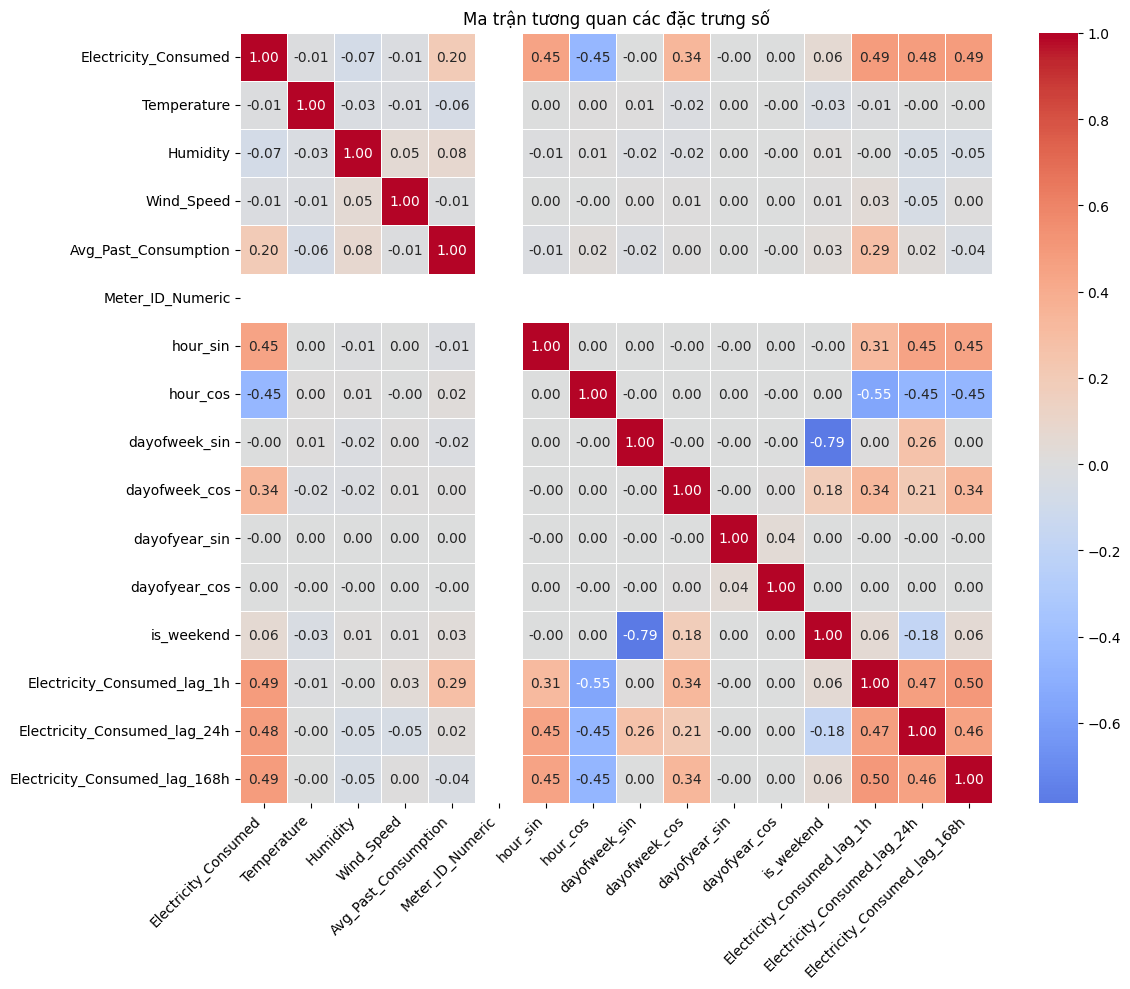

In [6]:
import pandas as pd
import os
import gzip

# Đường dẫn file
file_path = "C:/CODE/Python/11gb_data.csv"

# Kiểm tra kích thước file
print(f"📁 Kích thước file: {os.path.getsize(file_path) / (1024**3):.2f} GB")

# Kiểm tra xem file có phải gzip không
def is_gzip_file(filepath):
    with open(filepath, 'rb') as f:
        return f.read(2) == b'\x1f\x8b'  # magic number của gzip

is_gzip = is_gzip_file(file_path)
print(f"🧪 File là gzip? {'✅ Có' if is_gzip else '❌ Không'}")

# Đọc file với đúng chế độ
try:
    if is_gzip:
        df_chunk = pd.read_csv(file_path, compression='gzip', nrows=100_000)
    else:
        df_chunk = pd.read_csv(file_path, nrows=100_000)
    
    print("✅ Đọc dữ liệu thành công!")
    
    # Thông tin cơ bản
    print("📌 Kích thước chunk đầu tiên:", df_chunk.shape)
    print("\n📌 Tên cột:", df_chunk.columns.tolist())
    print("\n📌 Kiểu dữ liệu:")
    print(df_chunk.dtypes)

    # Kiểm tra dữ liệu thiếu
    print("\n📌 Số lượng giá trị thiếu:")
    print(df_chunk.isnull().sum())

    # Thống kê mô tả cơ bản
    print("\n📌 Thống kê mô tả:")
    print(df_chunk.describe(include='all', datetime_is_numeric=True))

    # Hiển thị 5 dòng đầu
    print("\n📌 5 dòng đầu tiên:")
    print(df_chunk.head())

except Exception as e:
    print(f"❌ Lỗi khi đọc file: {e}")




    import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Đọc 1 file Parquet ví dụ ---
df = pd.read_parquet("E:/processed_parquet_data/chunk_00000.parquet")

# --- Chọn các cột số ---
numeric_df = df.select_dtypes(include='number')

# --- Tính ma trận tương quan ---
corr_matrix = numeric_df.corr()

# --- Vẽ heatmap ---
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Ma trận tương quan các đặc trưng số")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



Bắt đầu kiểm tra dữ liệu để đánh giá sự phù hợp với mô hình chuỗi thời gian (LSTM, GRU, Informer)...

--- 1. Kiểm tra tổng quan file ---
   Kích thước file: 11.00 GB (Mục tiêu: ~11.00 GB)
   -> Kích thước file đạt yêu cầu.

--- 2. Lấy danh sách Meter_ID và chọn mẫu ---
   Đã xử lý 9,900,000 hàng để đếm công tơ duy nhất...
   Đã xử lý 19,900,000 hàng để đếm công tơ duy nhất...
   Đã xử lý 29,900,000 hàng để đếm công tơ duy nhất...
   Đã xử lý 39,900,000 hàng để đếm công tơ duy nhất...
   Đã xử lý 49,900,000 hàng để đếm công tơ duy nhất...
   Đã xử lý 59,900,000 hàng để đếm công tơ duy nhất...
   Đã xử lý 69,900,000 hàng để đếm công tơ duy nhất...
   Đã xử lý 79,900,000 hàng để đếm công tơ duy nhất...
   Đã xử lý 89,900,000 hàng để đếm công tơ duy nhất...
   Đã xử lý 99,900,000 hàng để đếm công tơ duy nhất...
   Đã xử lý 109,900,000 hàng để đếm công tơ duy nhất...
   Đã xử lý 119,900,000 hàng để đếm công tơ duy nhất...
   Tổng số Meter_ID duy nhất được tìm thấy trong file: 278
   Đã chọn

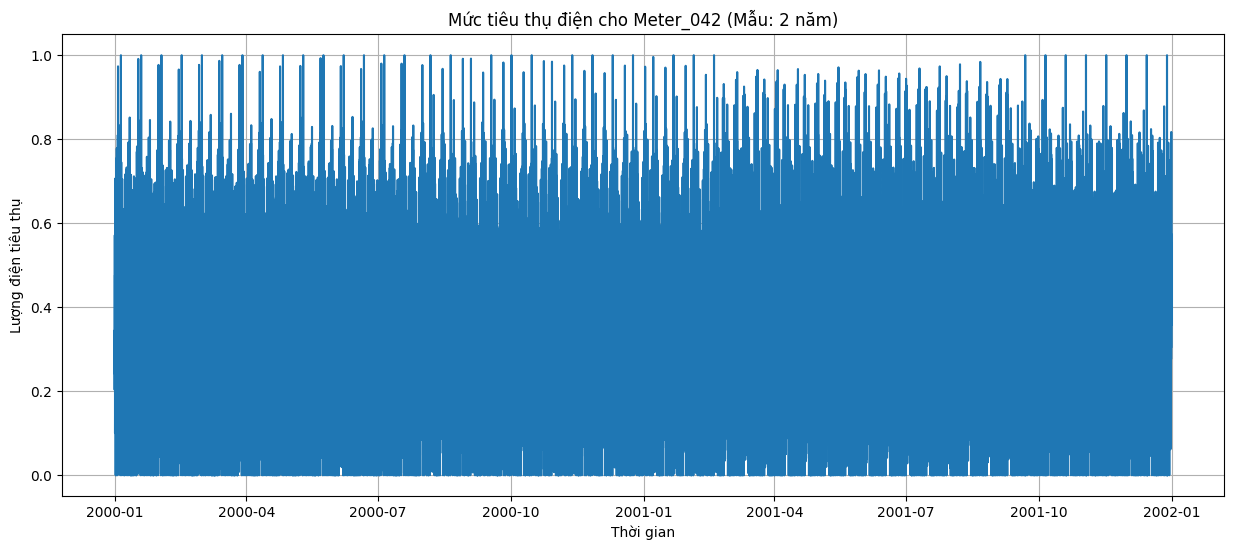

     -> Quan sát biểu đồ để thấy xu hướng (tăng/giảm tổng thể) và tính thời vụ (mô hình lặp lại).


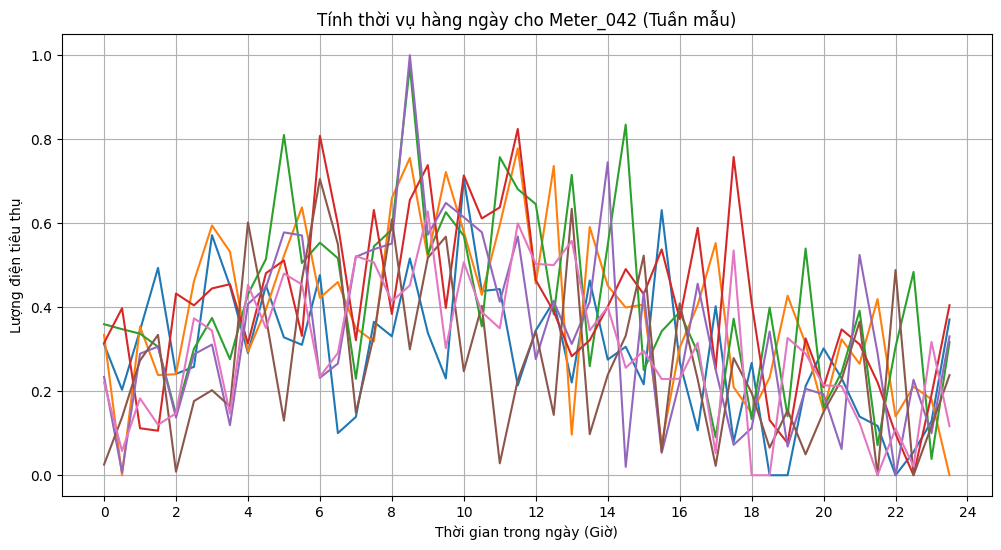

     -> Biểu đồ chồng lên nhau của các ngày/tuần giúp nhận diện các mẫu lặp lại trong ngày/tuần.
   - 3.5. Biểu đồ ACF và PACF (cột 'Electricity_Consumed'):


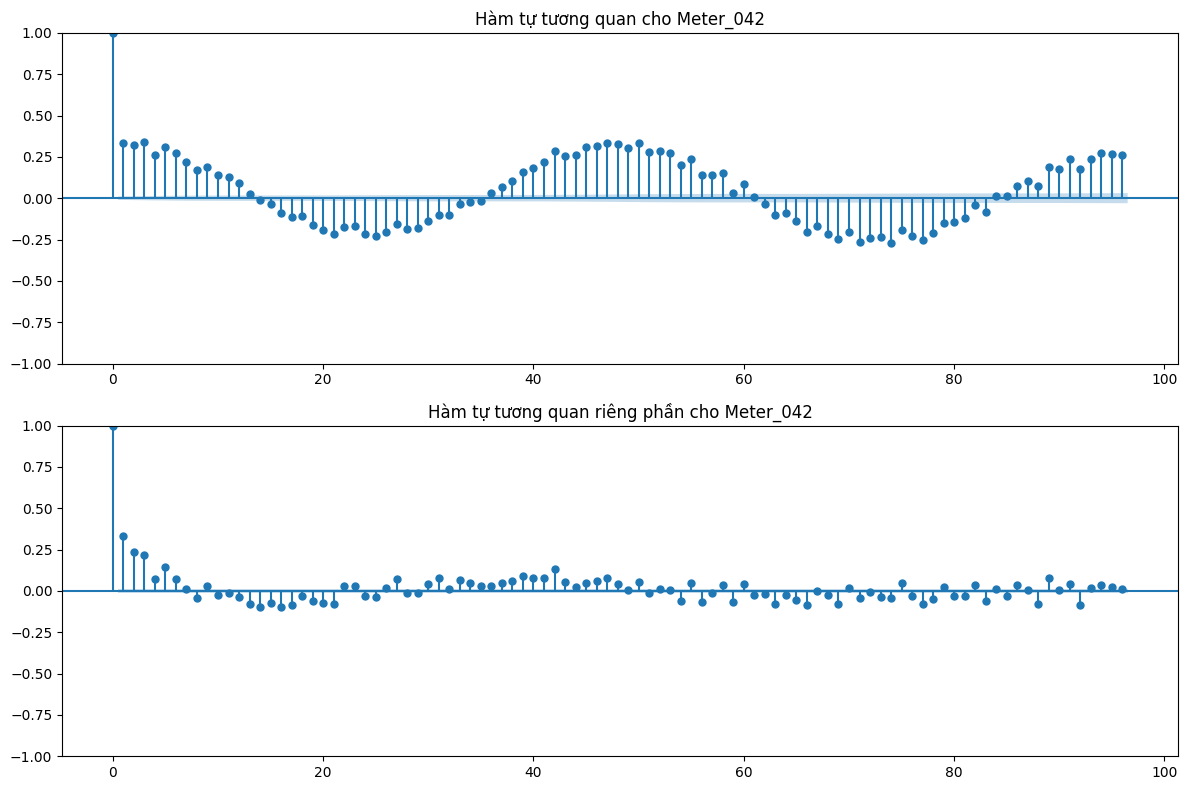

     -> Quan sát biểu đồ ACF để tìm đỉnh tại các độ trễ liên quan đến chu kỳ (48 cho ngày, 48*7 cho tuần). Điều này có thể giúp thiết kế các đặc trưng cho mô hình NN.
     -> Quan sát biểu đồ PACF để xác định mối quan hệ trực tiếp tại các độ trễ khác nhau, hữu ích cho việc hiểu cấu trúc dữ liệu.

Phân tích công tơ: Meter_179
   Đang tải dữ liệu cho Meter_179...
     Đã xử lý 9,900,000 hàng từ file chính...
     Đã xử lý 19,900,000 hàng từ file chính...
     Đã xử lý 29,900,000 hàng từ file chính...
     Đã xử lý 39,900,000 hàng từ file chính...
     Đã xử lý 49,900,000 hàng từ file chính...
     Đã xử lý 59,900,000 hàng từ file chính...
     Đã xử lý 69,900,000 hàng từ file chính...
   Đã tải 35,064 hàng cho Meter_179.
   - 3.1. Kiểm tra tính liên tục và tần suất Timestamp:
     -> Tần suất dữ liệu 0:30:00 rất nhất quán (35063/35063 đúng). Phù hợp cho chuỗi thời gian.
   - 3.2. Kiểm tra dải giá trị của 'Electricity_Consumed':
     -> Min: 0.0000, Max: 1.0000
     -> Dải giá trị [0, 1] 

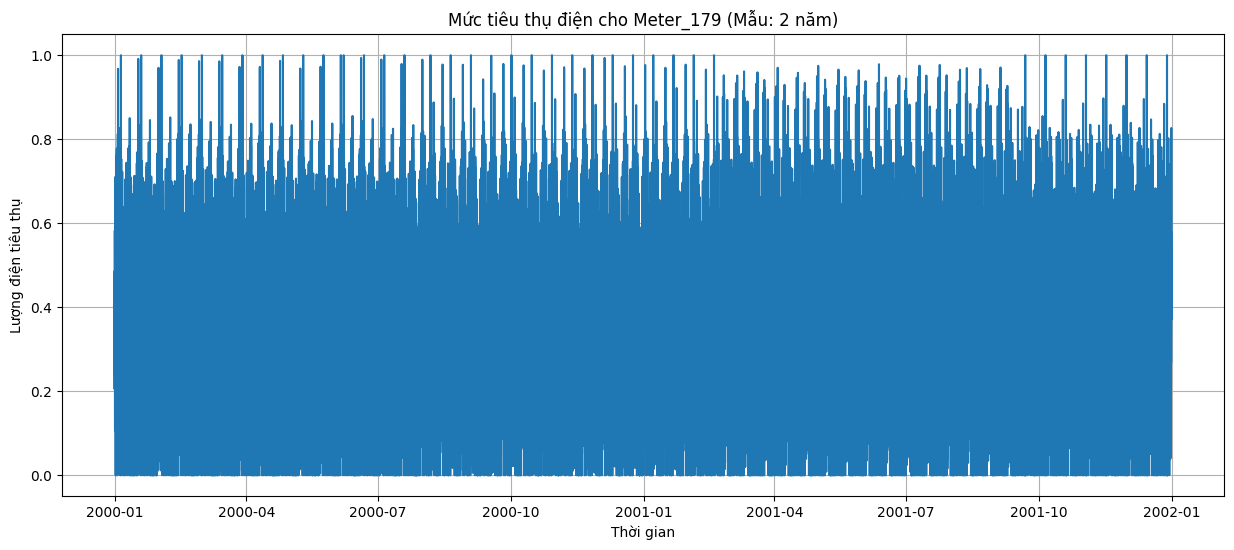

     -> Quan sát biểu đồ để thấy xu hướng (tăng/giảm tổng thể) và tính thời vụ (mô hình lặp lại).


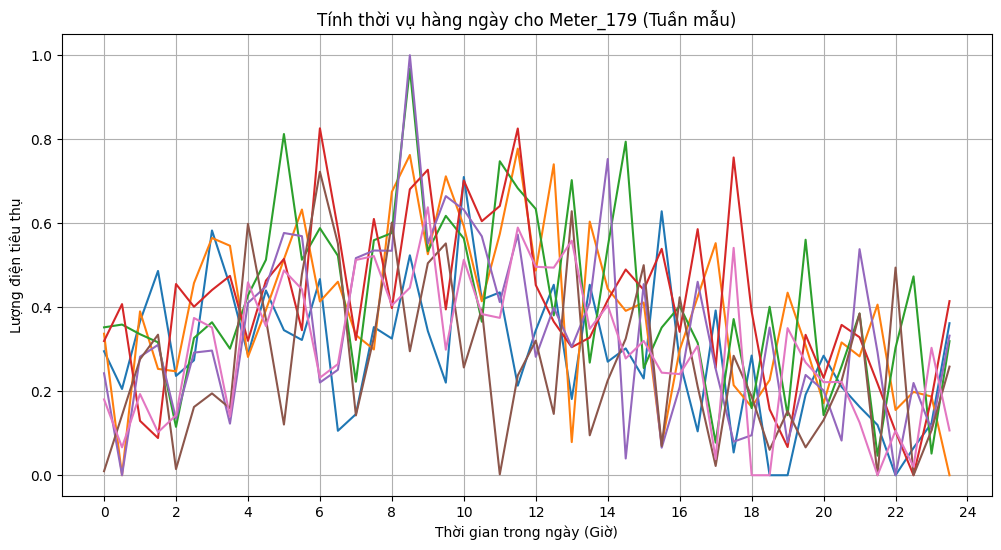

     -> Biểu đồ chồng lên nhau của các ngày/tuần giúp nhận diện các mẫu lặp lại trong ngày/tuần.
   - 3.5. Biểu đồ ACF và PACF (cột 'Electricity_Consumed'):


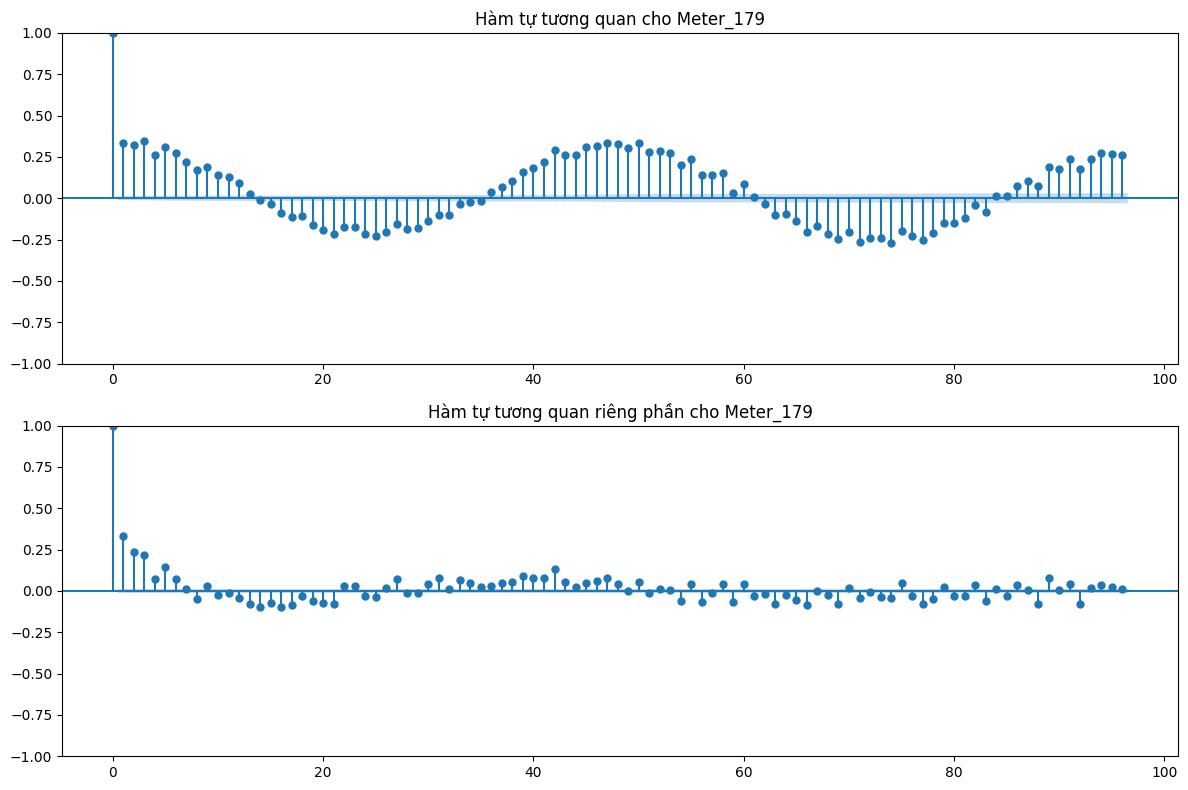

     -> Quan sát biểu đồ ACF để tìm đỉnh tại các độ trễ liên quan đến chu kỳ (48 cho ngày, 48*7 cho tuần). Điều này có thể giúp thiết kế các đặc trưng cho mô hình NN.
     -> Quan sát biểu đồ PACF để xác định mối quan hệ trực tiếp tại các độ trễ khác nhau, hữu ích cho việc hiểu cấu trúc dữ liệu.

Phân tích công tơ: Meter_151
   Đang tải dữ liệu cho Meter_151...
     Đã xử lý 9,900,000 hàng từ file chính...
     Đã xử lý 19,900,000 hàng từ file chính...
     Đã xử lý 29,900,000 hàng từ file chính...
     Đã xử lý 39,900,000 hàng từ file chính...
     Đã xử lý 49,900,000 hàng từ file chính...
     Đã xử lý 59,900,000 hàng từ file chính...
   Đã tải 35,064 hàng cho Meter_151.
   - 3.1. Kiểm tra tính liên tục và tần suất Timestamp:
     -> Tần suất dữ liệu 0:30:00 rất nhất quán (35063/35063 đúng). Phù hợp cho chuỗi thời gian.
   - 3.2. Kiểm tra dải giá trị của 'Electricity_Consumed':
     -> Min: 0.0000, Max: 1.0000
     -> Dải giá trị [0, 1] phù hợp cho các mô hình NN sau chuẩn hóa.
   - 

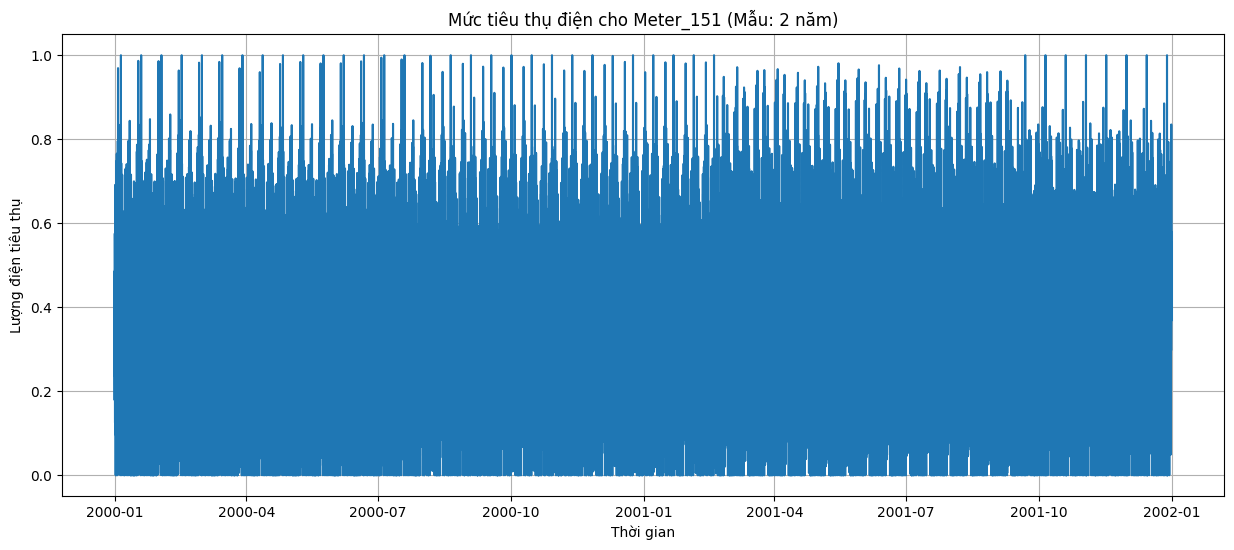

     -> Quan sát biểu đồ để thấy xu hướng (tăng/giảm tổng thể) và tính thời vụ (mô hình lặp lại).


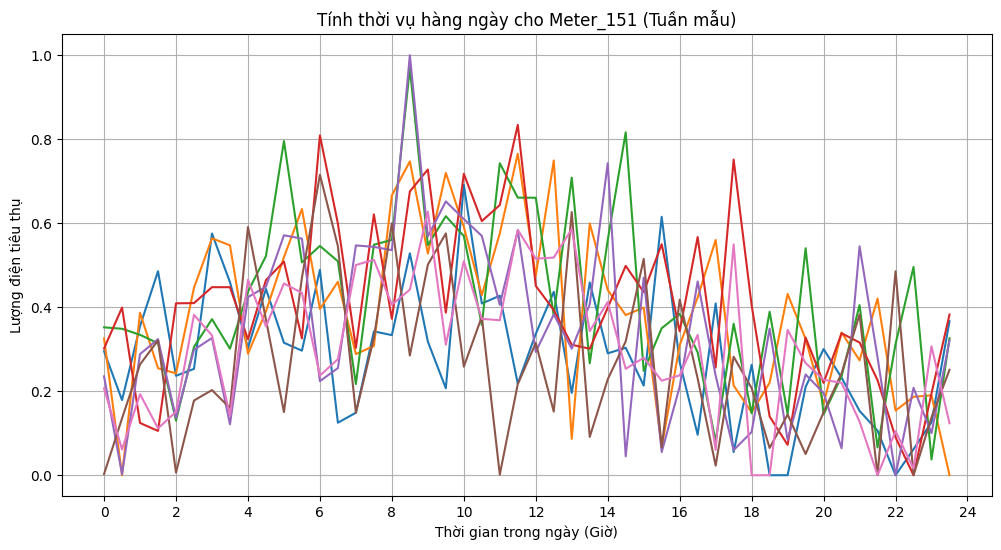

     -> Biểu đồ chồng lên nhau của các ngày/tuần giúp nhận diện các mẫu lặp lại trong ngày/tuần.
   - 3.5. Biểu đồ ACF và PACF (cột 'Electricity_Consumed'):


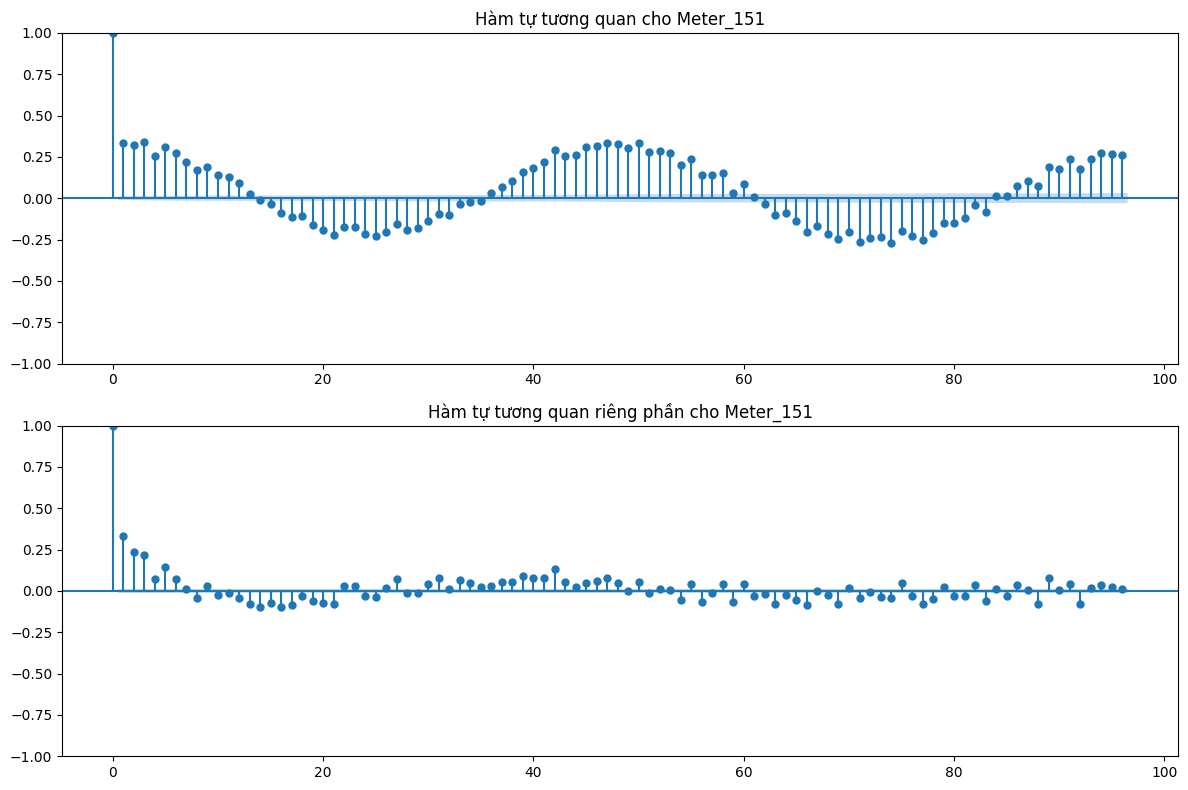

     -> Quan sát biểu đồ ACF để tìm đỉnh tại các độ trễ liên quan đến chu kỳ (48 cho ngày, 48*7 cho tuần). Điều này có thể giúp thiết kế các đặc trưng cho mô hình NN.
     -> Quan sát biểu đồ PACF để xác định mối quan hệ trực tiếp tại các độ trễ khác nhau, hữu ích cho việc hiểu cấu trúc dữ liệu.

Đã hoàn thành quá trình kiểm tra chi tiết dữ liệu cho các mô hình chuỗi thời gian.

--- Tóm tắt đánh giá ---
Để dữ liệu phù hợp với:
1.  **LSTM / GRU / Informer (Mạng Nơ-ron):**
    -   Dữ liệu phải có tính liên tục và tần suất đều (30 phút một lần). Đây là yếu tố rất quan trọng.
    -   Có ít hoặc không có giá trị bị thiếu (NaN). Nếu có, cần xử lý (điền vào, nội suy).
    -   Dải giá trị nên được chuẩn hóa (ví dụ: [0, 1] hoặc [-1, 1]). Dải hiện tại [0, 1] là tốt.
    -   Xu hướng và tính thời vụ rõ ràng sẽ giúp mô hình học tốt hơn. Các đặc trưng dựa trên thời gian (giờ trong ngày, ngày trong tuần, ngày trong năm, v.v.) có thể được thêm vào làm đầu vào ngoại sinh để giúp mô hình nắm bắt các mẫ

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import random
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import sys

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Cấu hình các hằng số ---
output_large_file_path = '11gb_data.csv'
TARGET_FILE_SIZE_BYTES = 11 * 1024**3 # 11 GB
NUM_METERS_TO_GENERATE = 300
start_gen_date_overall = datetime(2000, 1, 1)
ROWS_PER_DAY = 48 # Tần suất 30 phút một lần

# Ước tính tổng số hàng và số năm thực tế mỗi công tơ
ESTIMATED_BYTES_PER_ROW_UNCOMPRESSED = 90
TOTAL_ROWS_TARGET = TARGET_FILE_SIZE_BYTES // ESTIMATED_BYTES_PER_ROW_UNCOMPRESSED
ACTUAL_ROWS_PER_METER = TOTAL_ROWS_TARGET // NUM_METERS_TO_GENERATE
ACTUAL_YEARS_PER_METER = (ACTUAL_ROWS_PER_METER // ROWS_PER_DAY) / 365.25

# --- Cấu hình kiểm tra ---
CHUNK_SIZE_READ_ROWS = 100_000
NUM_SAMPLE_METERS_FOR_DETAILED_CHECK = 3
YEARS_TO_LOAD_PER_SAMPLE_METER = 2

print("Bắt đầu kiểm tra dữ liệu để đánh giá sự phù hợp với mô hình chuỗi thời gian (LSTM, GRU, Informer)...")

# 0. Kiểm tra sự tồn tại của file
if not os.path.exists(output_large_file_path):
    print(f"Lỗi: Không tìm thấy file '{output_large_file_path}'. Vui lòng đảm bảo file đã được sinh ra và nằm trong cùng thư mục.")
    sys.exit(1)

# 1. Kiểm tra kích thước file
file_size_bytes = os.path.getsize(output_large_file_path)
file_size_gb = file_size_bytes / (1024**3)
print(f"\n--- 1. Kiểm tra tổng quan file ---")
print(f"   Kích thước file: {file_size_gb:.2f} GB (Mục tiêu: ~{TARGET_FILE_SIZE_BYTES / (1024**3):.2f} GB)")
if abs(file_size_gb - (TARGET_FILE_SIZE_BYTES / (1024**3))) < 0.5:
    print("   -> Kích thước file đạt yêu cầu.")
else:
    print("   -> Cảnh báo: Kích thước file khác biệt đáng kể so với mục tiêu. Có thể dữ liệu chưa được sinh đủ.")

# 2. Lấy danh sách các Meter_ID và chọn ngẫu nhiên vài Meter_ID để kiểm tra chi tiết
print("\n--- 2. Lấy danh sách Meter_ID và chọn mẫu ---")

# Đếm tổng số Meter_ID duy nhất
unique_meter_ids_in_file = set()
for i, chunk in enumerate(pd.read_csv(output_large_file_path, chunksize=CHUNK_SIZE_READ_ROWS)):
    unique_meter_ids_in_file.update(chunk['Meter_ID'].unique())
    if (i + 1) % 100 == 0:
        print(f"   Đã xử lý {i*CHUNK_SIZE_READ_ROWS:,} hàng để đếm công tơ duy nhất...")

all_meter_ids_from_file = sorted(list(unique_meter_ids_in_file))
print(f"   Tổng số Meter_ID duy nhất được tìm thấy trong file: {len(all_meter_ids_from_file)}")

random_sample_meter_ids = random.sample(all_meter_ids_from_file, min(len(all_meter_ids_from_file), NUM_SAMPLE_METERS_FOR_DETAILED_CHECK))
print(f"   Đã chọn {len(random_sample_meter_ids)} công tơ ngẫu nhiên để phân tích chi tiết: {random_sample_meter_ids}")

# Hàm trợ giúp để tải dữ liệu cho một Meter_ID cụ thể
def load_specific_meter_data(meter_id_to_load, file_path, chunk_size, num_years_to_load=None):
    print(f"   Đang tải dữ liệu cho {meter_id_to_load}...")
    meter_data_chunks = []
    end_date_for_sample = None
    if num_years_to_load:
        end_date_for_sample = start_gen_date_overall + timedelta(days=num_years_to_load * 365.25)

    for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunk_size, parse_dates=['Timestamp'])):
        filtered_chunk = chunk[chunk['Meter_ID'] == meter_id_to_load].copy()

        if not filtered_chunk.empty:
            meter_data_chunks.append(filtered_chunk)
            if num_years_to_load and filtered_chunk['Timestamp'].max() >= end_date_for_sample:
                break

        if (i + 1) % 100 == 0:
            print(f"     Đã xử lý {i*chunk_size:,} hàng từ file chính...")

    if not meter_data_chunks:
        print(f"   Không tìm thấy dữ liệu cho {meter_id_to_load}.")
        return pd.DataFrame()

    df_meter = pd.concat(meter_data_chunks).sort_values('Timestamp').reset_index(drop=True)
    if num_years_to_load and not df_meter.empty:
        df_meter = df_meter[df_meter['Timestamp'] < end_date_for_sample].copy()

    print(f"   Đã tải {len(df_meter):,} hàng cho {meter_id_to_load}.")
    return df_meter

# 3. Phân tích chi tiết từng công tơ mẫu
print("\n--- 3. Phân tích chi tiết các công tơ mẫu ---")
for meter_id in random_sample_meter_ids:
    print(f"\nPhân tích công tơ: {meter_id}")
    df_meter = load_specific_meter_data(meter_id, output_large_file_path, CHUNK_SIZE_READ_ROWS, YEARS_TO_LOAD_PER_SAMPLE_METER)

    if df_meter.empty:
        print(f"   Không có dữ liệu để phân tích cho {meter_id}.")
        continue

    # 3.1. Kiểm tra tính liên tục và tần suất Timestamp
    print(f"   - 3.1. Kiểm tra tính liên tục và tần suất Timestamp:")
    if len(df_meter) > 1:
        time_diffs = df_meter['Timestamp'].diff().dropna()
        expected_freq = timedelta(minutes=30)
        correct_freq_count = (time_diffs == expected_freq).sum()
        total_diffs = len(time_diffs)

        if total_diffs > 0 and (correct_freq_count / total_diffs) > 0.98:
            print(f"     -> Tần suất dữ liệu {expected_freq} rất nhất quán ({correct_freq_count}/{total_diffs} đúng). Phù hợp cho chuỗi thời gian.")
        else:
            print(f"     -> Cảnh báo: Tần suất dữ liệu không nhất quán ({correct_freq_count}/{total_diffs} đúng). Có thể có lỗ hổng hoặc tần suất không đều.")
            print(f"       Khoảng cách thời gian phổ biến nhất: {time_diffs.mode().iloc[0] if not time_diffs.empty else 'N/A'}")
            print(f"       Số lượng khoảng cách khác 30 phút: {total_diffs - correct_freq_count}")
    else:
        print("     -> Không đủ dữ liệu để kiểm tra tần suất.")

    # 3.2. Kiểm tra Dải giá trị (Electricity_Consumed)
    print(f"   - 3.2. Kiểm tra dải giá trị của 'Electricity_Consumed':")
    if 'Electricity_Consumed' in df_meter.columns:
        min_val = df_meter['Electricity_Consumed'].min()
        max_val = df_meter['Electricity_Consumed'].max()
        print(f"     -> Min: {min_val:.4f}, Max: {max_val:.4f}")
        if min_val >= 0 and max_val <= 1:
            print("     -> Dải giá trị [0, 1] phù hợp cho các mô hình NN sau chuẩn hóa.")
        else:
            print("     -> Cảnh báo: Dải giá trị ngoài [0, 1]. Có thể cần chuẩn hóa lại.")
    else:
        print("     -> Không tìm thấy cột 'Electricity_Consumed'.")

    # 3.3. Kiểm tra tính dừng (Stationarity) với ADF Test
    print(f"   - 3.3. Kiểm tra tính dừng (Stationarity) với ADF Test (cột 'Electricity_Consumed'):")
    if 'Electricity_Consumed' in df_meter.columns and len(df_meter) > 50:
        try:
            adf_result = adfuller(df_meter['Electricity_Consumed'].dropna())
            adf_statistic = adf_result[0]
            p_value = adf_result[1]
            print(f"     -> Thống kê ADF: {adf_statistic:.2f}")
            print(f"     -> Giá trị P: {p_value:.3f}")
            if p_value < 0.05:
                print("     -> Dữ liệu có thể là dừng (stationary) hoặc cần ít sai phân. Các mô hình NN có thể hưởng lợi từ dữ liệu dừng.")
            else:
                print("     -> Cảnh báo: Dữ liệu có thể không dừng (non-stationary). Các mô hình NN có thể xử lý tốt hơn nhưng việc hiểu tính dừng có thể hỗ trợ chuẩn bị dữ liệu.")
        except Exception as e:
            print(f"     -> Không thể thực hiện ADF Test: {e}. Đảm bảo dữ liệu không có NaN.")
    else:
        print("     -> Không đủ dữ liệu hoặc cột 'Electricity_Consumed' không khả dụng để kiểm tra tính dừng.")

    # 3.4. Kiểm tra tính thời vụ (Seasonality) và xu hướng (Trend) bằng biểu đồ
    print(f"   - 3.4. Kiểm tra tính thời vụ (Seasonality) và xu hướng (Trend) bằng biểu đồ:")
    plt.figure(figsize=(15, 6))
    plt.plot(df_meter['Timestamp'], df_meter['Electricity_Consumed'])
    plt.title(f'Mức tiêu thụ điện cho {meter_id} (Mẫu: {YEARS_TO_LOAD_PER_SAMPLE_METER} năm)')
    plt.xlabel('Thời gian')
    plt.ylabel('Lượng điện tiêu thụ')
    plt.grid(True)
    plt.show()
    print("     -> Quan sát biểu đồ để thấy xu hướng (tăng/giảm tổng thể) và tính thời vụ (mô hình lặp lại).")

    if len(df_meter) > ROWS_PER_DAY * 7:
        plt.figure(figsize=(12, 6))
        start_plot_date = df_meter['Timestamp'].iloc[0]
        end_plot_date = start_plot_date + timedelta(days=7)

        df_week_sample = df_meter[(df_meter['Timestamp'] >= start_plot_date) & (df_meter['Timestamp'] < end_plot_date)].copy()
        df_week_sample['time_in_hours'] = df_week_sample['Timestamp'].dt.hour + df_week_sample['Timestamp'].dt.minute / 60

        for day in df_week_sample['Timestamp'].dt.date.unique():
            df_day = df_week_sample[df_week_sample['Timestamp'].dt.date == day]
            plt.plot(df_day['time_in_hours'], df_day['Electricity_Consumed'], label=day.strftime('%Y-%m-%d'))

        plt.title(f'Tính thời vụ hàng ngày cho {meter_id} (Tuần mẫu)')
        plt.xlabel('Thời gian trong ngày (Giờ)')
        plt.ylabel('Lượng điện tiêu thụ')
        plt.xticks(np.arange(0, 25, 2))
        plt.grid(True)
        plt.show()
        print("     -> Biểu đồ chồng lên nhau của các ngày/tuần giúp nhận diện các mẫu lặp lại trong ngày/tuần.")
    else:
        print("     -> Không đủ dữ liệu để vẽ biểu đồ chu kỳ ngày/tuần.")

    # 3.5. Biểu đồ ACF và PACF
    print(f"   - 3.5. Biểu đồ ACF và PACF (cột 'Electricity_Consumed'):")
    if 'Electricity_Consumed' in df_meter.columns and len(df_meter) > 2 * ROWS_PER_DAY:
        try:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
            plot_acf(df_meter['Electricity_Consumed'].dropna(), lags=ROWS_PER_DAY * 2, ax=ax1, title=f'Hàm tự tương quan cho {meter_id}')
            plot_pacf(df_meter['Electricity_Consumed'].dropna(), lags=ROWS_PER_DAY * 2, ax=ax2, title=f'Hàm tự tương quan riêng phần cho {meter_id}')
            plt.tight_layout()
            plt.show()
            print("     -> Quan sát biểu đồ ACF để tìm đỉnh tại các độ trễ liên quan đến chu kỳ (48 cho ngày, 48*7 cho tuần). Điều này có thể giúp thiết kế các đặc trưng cho mô hình NN.")
            print("     -> Quan sát biểu đồ PACF để xác định mối quan hệ trực tiếp tại các độ trễ khác nhau, hữu ích cho việc hiểu cấu trúc dữ liệu.")
        except Exception as e:
            print(f"     -> Không thể vẽ biểu đồ ACF/PACF: {e}. Đảm bảo dữ liệu không có NaN.")
    else:
        print("     -> Không đủ dữ liệu hoặc cột 'Electricity_Consumed' không khả dụng để vẽ biểu đồ ACF/PACF.")

print("\nĐã hoàn thành quá trình kiểm tra chi tiết dữ liệu cho các mô hình chuỗi thời gian.")
print("\n--- Tóm tắt đánh giá ---")
print("Để dữ liệu phù hợp với:")
print("1.  **LSTM / GRU / Informer (Mạng Nơ-ron):**")
print("    -   Dữ liệu phải có tính liên tục và tần suất đều (30 phút một lần). Đây là yếu tố rất quan trọng.")
print("    -   Có ít hoặc không có giá trị bị thiếu (NaN). Nếu có, cần xử lý (điền vào, nội suy).")
print("    -   Dải giá trị nên được chuẩn hóa (ví dụ: [0, 1] hoặc [-1, 1]). Dải hiện tại [0, 1] là tốt.")
print("    -   Xu hướng và tính thời vụ rõ ràng sẽ giúp mô hình học tốt hơn. Các đặc trưng dựa trên thời gian (giờ trong ngày, ngày trong tuần, ngày trong năm, v.v.) có thể được thêm vào làm đầu vào ngoại sinh để giúp mô hình nắm bắt các mẫu này.")
print("    -   Mặc dù tính dừng không bắt buộc đối với các mô hình mạng nơ-ron như LSTM/GRU/Informer, dữ liệu dừng đôi khi có thể dẫn đến quá trình học ổn định hơn. Tuy nhiên, các mô hình này vốn có khả năng học các mối quan hệ phức tạp trong dữ liệu không dừng.")
print("\nSau khi chạy script này, hãy xem xét kỹ các biểu đồ và kết quả kiểm tra để đưa ra đánh giá cuối cùng.")

In [18]:
import pandas as pd
import os
import sys
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Cấu hình hằng số ---
output_large_file_path = '11gb_data.csv'
NUM_ROWS_TO_DISPLAY = 30000000 # Số dòng dữ liệu muốn hiển thị

print("Bắt đầu hiển thị dữ liệu từ file CSV lớn...")

# 0. Kiểm tra sự tồn tại của file
if not os.path.exists(output_large_file_path):
    print(f"Lỗi: Không tìm thấy file '{output_large_file_path}'. Vui lòng đảm bảo file đã được sinh ra và nằm trong cùng thư mục.")
    sys.exit(1)

# 1. Kiểm tra kích thước file
file_size_bytes = os.path.getsize(output_large_file_path)
file_size_gb = file_size_bytes / (1024**3)
print(f"\n--- 1. Kiểm tra tổng quan file ---")
print(f"   Kích thước file: {file_size_gb:.2f} GB")

# 2. Đọc và hiển thị 30 dòng dữ liệu đầu tiên
print(f"\n--- 2. Đang đọc và hiển thị {NUM_ROWS_TO_DISPLAY} dòng dữ liệu đầu tiên từ file '{output_large_file_path}' ---")

df_preview = pd.DataFrame() # Khởi tạo df_preview để tránh lỗi nếu try block thất bại
try:
    # Tùy chỉnh hiển thị để không bị cắt cột
    pd.set_option('display.max_columns', None)  # Hiển thị tất cả các cột
    pd.set_option('display.width', 1000)        # Đặt chiều rộng hiển thị

    # Chỉ đọc số lượng dòng cần thiết để tránh tải toàn bộ file lớn
    df_preview = pd.read_csv(output_large_file_path, nrows=NUM_ROWS_TO_DISPLAY, parse_dates=['Timestamp'])

    if not df_preview.empty:
        print(df_preview)
    else:
        print("   File CSV trống hoặc không có đủ dữ liệu để hiển thị.")

except Exception as e:
    print(f"Lỗi khi đọc file CSV: {e}")
finally:
    # Đặt lại tùy chọn mặc định sau khi in để không ảnh hưởng đến các hoạt động pandas khác
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')

# 3. Kiểm tra giá trị âm trong tất cả các cột số (trong 30 dòng đã đọc)
print(f"\n--- 3. Kiểm tra giá trị âm trong tất cả các cột số (trong {NUM_ROWS_TO_DISPLAY} dòng đầu tiên) ---")

if not df_preview.empty:
    numeric_cols = df_preview.select_dtypes(include=np.number).columns.tolist()
    found_negative = False

    for col in numeric_cols:
        negative_values_in_col = df_preview[df_preview[col] < 0]
        if not negative_values_in_col.empty:
            print(f"   -> Cảnh báo: Tìm thấy giá trị âm trong cột '{col}'!")
            # Chỉ hiển thị các cột liên quan để dễ đọc
            print(negative_values_in_col[['Timestamp', 'Meter_ID', col]])
            found_negative = True
    
    if not found_negative:
        print("   -> Không tìm thấy giá trị âm trong bất kỳ cột số nào trong các dòng đã đọc.")
else:
    print("   -> Không có dữ liệu để kiểm tra giá trị âm.")

print("\nHoàn tất việc hiển thị và kiểm tra dữ liệu cơ bản.")

Bắt đầu hiển thị dữ liệu từ file CSV lớn...

--- 1. Kiểm tra tổng quan file ---
   Kích thước file: 11.00 GB

--- 2. Đang đọc và hiển thị 30000000 dòng dữ liệu đầu tiên từ file '11gb_data.csv' ---
                   Timestamp   Meter_ID  Electricity_Consumed  Temperature  Humidity  Wind_Speed  Avg_Past_Consumption
0        2000-01-01 00:00:00  Meter_001              0.294639     0.469524  0.396368    0.445441              0.692057
1        2000-01-01 00:30:00  Meter_001              0.187277     0.465545  0.451184    0.458729              0.539874
2        2000-01-01 01:00:00  Meter_001              0.357767     0.285415  0.408289    0.470360              0.614724
3        2000-01-01 01:30:00  Meter_001              0.494676     0.482095  0.512308    0.576241              0.757044
4        2000-01-01 02:00:00  Meter_001              0.252935     0.624741  0.672021    0.373004              0.673981
...                      ...        ...                   ...          ...       ...     